# Factor Selection

In [1]:
from WindPy import w
import pandas as pd
import numpy as np
import os
import shutil
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.api import het_white, het_breuschpagan
from statsmodels.stats.sandwich_covariance import cov_hac
from statsmodels.tsa.seasonal import STL
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

24.2.0.60020


In [2]:
w.start()

2024-07-08 10:26:21.215 Python[14690:1044074] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


Wind.Cosmos.Base V1.7 compiled time is Apr 17 2023, BuildType:Release, CPUArch:X64, GCC Version:Apple LLVM 13.0.0 (clang-1300.0.29.30)
Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [24]:
start_date = "2008-12-01" # actually from 2010, extract data for preprocessing
end_date = "2024-06-30"

In [4]:
# takes a dict of indicators and their corresponding ticker in Wind to
# create a DataFrame containing the data extracted from Wind API
def extract_inds(inds):
    df = pd.DataFrame()
    for ind in inds:
        raw = w.edb(inds[ind], start_date, end_date, Period="M")
        # Extract data from the Wind API response
        times = raw.Times
        data = raw.Data[0]
        # Convert times to pandas datetime format
        times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")
        
        # Create a temporary DataFrame for the current indicator
        temp_df = pd.DataFrame(data, index=times, columns=[ind])
        
        # Combine the temporary DataFrame with the main DataFrame
        if df.empty:
            df = temp_df
        else:
            df = df.join(temp_df, how='outer')
    return df

In [5]:
def lag_data(df, periods=1):
    df_lagged = df.shift(periods)
    df_lagged = df_lagged.iloc[periods:]  # Remove the first rows
    return df_lagged

In [6]:
def apply_x11(df, columns, x13as_path='/usr/local/bin/x13as'):
    tempdir = os.path.join(os.getcwd(), 'x13as_temp')
    os.makedirs(tempdir, exist_ok=True)

    df_adjusted = df.copy()
    for column in columns:
        ts = df[column].asfreq('M')
        
        # Handle zero or negative values
        min_value = ts.min()
        shift_value = abs(min_value) + 1 if min_value <= 0 else 0
        ts_shifted = ts + shift_value
        
        try:
            result = sm.tsa.x13_arima_analysis(ts_shifted, x12path=x13as_path, tempdir=tempdir)
            if result is None:
                raise ValueError(f"X-13ARIMA-SEATS returned None for column: {column}")
            
            # Adjust the seasonally adjusted data back
            df_adjusted[column] = result.seasadj - shift_value
            
        except Exception as e:
            print(f"Error processing column {column}: {e}")
            
            # Read and print the .err file for more details
            err_file_path = os.path.join(tempdir, 'x13as.err')
            if os.path.exists(err_file_path):
                with open(err_file_path, 'r') as err_file:
                    print(f"Error file content for column {column}:")
                    print(err_file.read())
            continue
    
    # Cleanup temporary directory
    shutil.rmtree(tempdir)

    return df_adjusted

In [7]:
# Logarithmic YoY Change Processing
def logyoy(df, columns):
    df_log_yoy = df.copy()
    for column in columns:
        df_log_yoy[column] = np.log(df[column] / df[column].shift(12)) * 100
    df_log_yoy = df_log_yoy.iloc[12:]  # Remove the first 12 rows where the shift operation would result in NaN
    return df_log_yoy

In [8]:
# for factor selection, regress on the exchang rate to observe Beta, T-Value, and R-Squared
# and record the median values after 1000 iterations
def regress(indicator_df, forex_df, target_column='USD/CNY Central Parity Rate', n_iterations=1000, min_period_length=24):
    # Initialize a DataFrame to store regression results
    forex_df.index = indicator_df.index
    results = []

    for i in range(n_iterations):
        # Resample with replacement
        sample_indices = np.random.choice(indicator_df.index, size=len(indicator_df), replace=True)
        sample_growth_df = indicator_df.loc[sample_indices]
        sample_forex_df = forex_df.loc[sample_indices]
        
        # Randomly select start and end dates
        start_idx = np.random.randint(0, len(sample_growth_df) - min_period_length)
        end_idx = start_idx + min_period_length
        
        # Subset the data to ensure period longer than 2 years
        sample_growth_period = sample_growth_df.iloc[start_idx:end_idx]
        sample_forex_period = sample_forex_df.iloc[start_idx:end_idx]
        
        # Perform regression for each indicator
        for indicator in indicator_df.columns:
            X = sample_growth_period[[indicator]]
            X = sm.add_constant(X)
            y = sample_forex_period[target_column]
            
            model = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})
            beta = model.params[indicator]
            t_value = model.tvalues[indicator]
            r_squared = model.rsquared
            
            # Append the results
            results.append({
                'Indicator': indicator,
                'Beta': beta,
                'T-Value': t_value,
                'R-Squared(%)': r_squared * 100  # Convert to percentage
            })
            
    # Convert results to DataFrame
    growth_results_df = pd.DataFrame(results)

    # Compute median values
    growth_median_results = growth_results_df.groupby('Indicator').median().reset_index()

    # Format the median results
    growth_median_results['Beta'] = growth_median_results['Beta'].map("{:.2f}".format)
    growth_median_results['T-Value'] = growth_median_results['T-Value'].map("{:.2f}".format)
    growth_median_results['R-Squared(%)'] = growth_median_results['R-Squared(%)'].map("{:.2f}%".format)

    return growth_median_results

In [29]:
# Get USD/CNH Exchange Rate
fx_data = w.edb("M0000185", "2009-01-01", end_date, Period="M")
# Parse the data
times = fx_data.Times
data = fx_data.Data[0]
times = pd.to_datetime([str(time) for time in times], format="%Y-%m-%d")

# Construct the DataFrame
df_forex = pd.DataFrame(data, index=times, columns=["USD/CNY Central Parity Rate"])
df_forex = logyoy(df_forex, df_forex.columns)
df_forex = df_forex[df_forex.index <= end_date]

# Display the DataFrame
df_forex

,USD/CNY Central Parity Rate
2010-01-29,-0.160995
2010-02-26,-0.160998
2010-03-31,-0.140534
2010-04-30,0.019046
2010-05-31,-0.064420
...,...
2024-02-29,2.158669
2024-03-29,3.197878
2024-04-30,2.598808
2024-05-31,0.376298


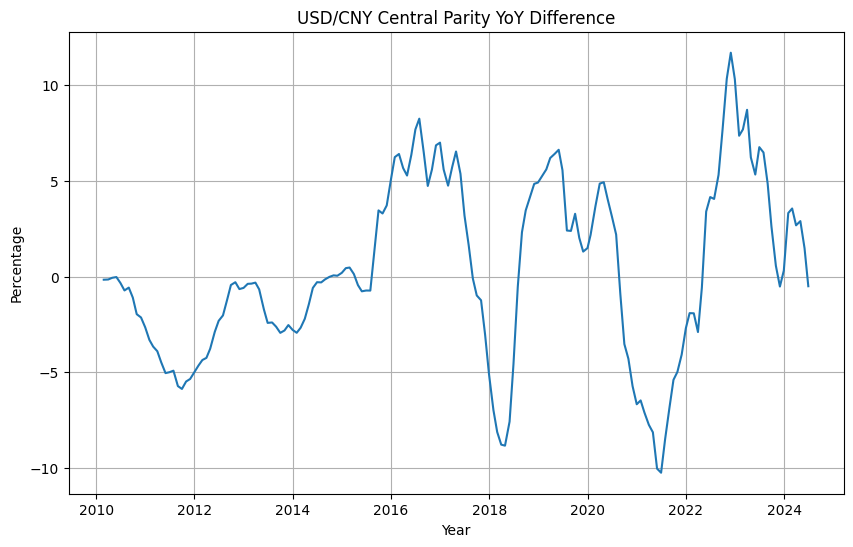

In [30]:
smoothed_fx = df_forex.rolling(window=2).mean()
plt.figure(figsize=(10, 6))
plt.plot(smoothed_fx.index, smoothed_fx[["USD/CNY Central Parity Rate"]])
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('USD/CNY Central Parity YoY Difference')
plt.grid(True)
plt.show()

In [31]:
def combine_factors(df1, columns_df1, df2=None, columns_df2=None, fx_rate = df_forex['USD/CNY Central Parity Rate']):
    inverse_volatilities = {}
    columns = {}

    # Process columns from df1
    for column in columns_df1:
        series = df1[column]
        correlation = series.corr(fx_rate)
        if correlation < 0:
            series = -series  # Invert the series if correlation is negative
        inverse_volatilities[column] = 1 / series.std()
        columns[column] = series

    # Process columns from df2 if provided
    if df2 is not None and columns_df2 is not None:
        for column in columns_df2:
            series = df2[column]
            correlation = series.corr(fx_rate)
            if correlation < 0:
                series = -series  # Invert the series if correlation is negative
            inverse_volatilities[column] = 1 / series.std()
            columns[column] = series

    total_inverse_volatility = sum(inverse_volatilities.values())

    weights = {key: inv_vol / total_inverse_volatility for key, inv_vol in inverse_volatilities.items()}

    combined_factor = sum(weights[key] * columns[key] for key in columns)

    return combined_factor, weights

In [32]:
# Function to calculate rolling average and plot the data
def plot_smoothed_data(category, factor, df, column, window_size=2):
    # Calculate rolling average (smoothing)
    smoothed_serie = df[column].rolling(window=window_size).mean()
    smoothed_factor = factor.rolling(window=window_size).mean()

    # Plotting the data
    plt.figure(figsize=(10, 6))
    plt.plot(smoothed_serie.index, smoothed_serie, label=f'{column} (Smoothed)', color="slategray")
    plt.plot(smoothed_factor.index, smoothed_factor, label=f'{category} Factor (Smoothed)', color="crimson")
    plt.xlabel('Year')
    plt.ylabel('% Change')
    plt.title(f'{category} Factor vs. {column}')
    plt.legend()
    plt.grid(True)
    plt.show()

## Growth Factor

In [13]:
# consider key growth indicators for China
china_growth_inds = {
    # production method
    # general macro indicators
    'GDP(%)': 'M0039354',
    'Industrial_Added_Value_(%)': 'M0000545',
    'PMI': 'M0017126',
    'Manufacturing_PMI': 'M0017127',
    'Manufacturing_PMI:New_Orders': 'M0017128',
    # by industry
    'Electricity_Production(%)': 'S0027013',
    'Output:Cement(%)': 'S0027703',
    'Output:Crude_Steel(%)': 'S0027375',
    'Output:Motor_Vehicles(%)': 'S0027908',
    'Railway_Freight_Traffic(%)': 'S0036034',
    # expenditure method
    # investments
    'FAI(%)': 'M0000273',
    'Completed_Investment_in_Real_Estate_Development(%)': 'S0029657',
    'FAI:Infrastructure_Investment(%)': 'M5440435',
    'FAI:Manufacturing(%)': 'M0000357',
    # consumption
    'Total_Retail_Sales_of_Consumer_Goods(%)': 'M0001428',
    'Sales:Vehicle(%)': 'S6114593',
    'Sales:Excavators(%)': 'S6002167',
    'Floor_Space_of_Commercial_Buildings_Sold(%)': 'S0073300',
    'Total_Sales_of_Commercial_Buildings(%)': 'S0049591',
    # net exports
    'Imports_and_Exports(%)': 'M0000605',
    'Exports(%)': 'M0000607',
    'Imports(%)': 'M0000609',
    'Exports_USA(%)': 'M0008499',
    # income method
    'Govt_Revenue(%)': 'M0046169',
    'Industrial_Enterprise:Total_Profits(%)': 'M0000557'
}
# for standardizing the PMI data
china_nonyoy_cols = ['PMI', 'Manufacturing_PMI', 'Manufacturing_PMI:New_Orders']

In [33]:
# actual step retrieving data from Wind API
df_china_growth = extract_inds(china_growth_inds)
df_china_growth = lag_data(df_china_growth)  # lag data by 1 period
df_china_growth = df_china_growth.interpolate(method="linear", limit_direction="both")  # interpolate missing values
df_china_growth = apply_x11(df_china_growth, df_china_growth.columns[1:])
df_china_growth = logyoy(df_china_growth, china_nonyoy_cols)
df_china_growth.head(10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant seasonal peak has been found
          in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:

,GDP(%),Industrial_Added_Value_(%),PMI,Manufacturing_PMI,Manufacturing_PMI:New_Orders,Electricity_Production(%),Output:Cement(%),Output:Crude_Steel(%),Output:Motor_Vehicles(%),Railway_Freight_Traffic(%),...,Sales:Vehicle(%),Sales:Excavators(%),Floor_Space_of_Commercial_Buildings_Sold(%),Total_Sales_of_Commercial_Buildings(%),Imports_and_Exports(%),Exports(%),Imports(%),Exports_USA(%),Govt_Revenue(%),Industrial_Enterprise:Total_Profits(%)
2010-01-31,11.900000,18.227415,32.035825,45.759635,50.111982,27.619025,11.233711,27.737821,120.454960,17.594121,...,86.942412,120.116402,39.915126,74.959842,31.493655,18.339876,53.989643,-13.308339,12.257796,38.967823
2010-02-28,12.000000,29.006867,20.557502,28.668732,28.489184,35.623269,52.343643,25.672172,135.095998,15.530641,...,123.528996,253.751079,38.232589,72.030988,44.597768,18.274046,89.514217,10.037418,40.750469,78.927756
2010-03-31,12.100000,11.839987,5.749610,5.870769,6.279932,2.855790,7.130239,21.460060,42.259922,16.276322,...,46.236329,2.183160,37.821268,68.381563,45.774922,44.644684,48.236998,21.501309,31.257509,119.609905
2010-04-30,12.200000,17.374825,5.258891,2.599920,6.619449,16.786480,14.271035,21.391327,45.940044,16.725587,...,55.601176,126.767662,35.736556,59.058524,40.515055,24.455422,66.156961,18.181999,32.097064,108.178044
2010-05-31,11.733333,18.097559,4.250729,3.013245,4.916303,23.546649,16.411724,29.055564,38.540501,14.665002,...,38.659562,106.964187,33.063022,55.866554,38.782581,29.265554,50.644844,18.767005,33.794735,97.081441
2010-06-30,11.266667,16.865302,1.515286,2.267085,-2.533860,19.300572,18.377128,22.209288,28.766839,12.217029,...,31.392426,112.611465,24.297030,40.874191,46.773940,46.260078,48.536926,23.456128,30.082448,85.661429
2010-07-31,10.800000,14.042462,-2.119456,-2.357499,-6.259625,11.376188,13.735552,10.782998,20.722820,11.455200,...,26.307813,80.407862,17.099570,27.979413,39.432330,42.972918,32.878753,27.362223,27.825047,76.240322
2010-08-31,10.500000,14.203087,-4.045446,-8.382191,-8.501852,12.161012,15.426097,3.038587,22.562894,10.304285,...,16.731333,57.109901,11.263721,18.778018,32.417137,38.590237,23.053791,29.307010,26.318762,67.011858
2010-09-30,10.200000,14.464705,-4.389694,-8.576137,-5.946727,12.101630,12.147261,0.313616,16.979071,10.175504,...,17.280871,43.986264,7.554122,13.003574,35.826309,35.188854,34.879484,31.554185,24.319468,57.102119
2010-10-31,9.900000,13.614824,-0.924024,-2.777655,-0.978046,9.538063,9.280803,-4.963733,22.818677,7.407418,...,16.040006,57.124910,8.636688,15.048737,25.996518,27.055529,23.764476,31.298077,23.221350,53.091473


In [35]:
china_growth_ctrb = regress(df_china_growth, df_forex)
china_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,Completed_Investment_in_Real_Estate_Developmen...,-0.20,-4.32,33.12%
1,Electricity_Production(%),-0.25,-1.79,9.74%
2,Exports(%),-0.17,-3.48,29.67%
3,Exports_USA(%),-0.17,-5.32,37.46%
4,FAI(%),-0.23,-3.22,22.07%
5,FAI:Infrastructure_Investment(%),-0.05,-0.68,2.05%
6,FAI:Manufacturing(%),-0.19,-2.72,20.93%
7,Floor_Space_of_Commercial_Buildings_Sold(%),-0.07,-1.54,8.89%
8,GDP(%),-0.82,-3.46,25.26%
9,Govt_Revenue(%),-0.21,-2.83,23.06%


connect And Re login ip:180.96.8.11 usPort:8443

In [36]:
us_growth_inds = {
        # production method
        # general macro indicators
        'GDP_US': 'G1112986',
        'Industrial_Production_Total_Index(%)': 'G1109285',
        'PMI': 'G0002323',
        'Manufacturing_PMI': 'G0008346',
        'ISM:Manufacturing_PMI:New_Orders': 'G0008345', 
        # by industry
        'Electricity_Net_Generation': 'G1130815',
        'RIW:Concrete_and_Product': 'D5715886',
        'Production:Crude_Steel(%)': 'S5709965',
        'Industrial_Production_Index_Autos': 'G1121656',
        # expenditure method
        # investment
        'Real_Estate_Loans': 'T7212500',
        # consumption
        'New_Houses_Sold': 'G0003650',
        'Auto_Sales': 'G1121638',
        'Retail_and_Food_Services_Sales(%)': 'G1113053',
        # net export
        'Goods_Balance(%)': 'G1113168',
        'Goods_Export(%)': 'G1113166',
        'Goods_Import(%)': 'G1113167',
        'Exports_China': 'G1101044',
        # income method
        'Receipts_of_Fed_Govt(%)': 'G1100347'
}
us_nonyoy_cols = ['PMI', 'Manufacturing_PMI', 'ISM:Manufacturing_PMI:New_Orders', 'Electricity_Net_Generation', 'RIW:Concrete_and_Product', 'Industrial_Production_Index_Autos', 'Real_Estate_Loans', 'New_Houses_Sold', 'Auto_Sales', 'Exports_China']
us_needsa_cols = ['PMI', 'Manufacturing_PMI', 'ISM:Manufacturing_PMI:New_Orders', 'Electricity_Net_Generation', 'Production:Crude_Steel(%)', 'Auto_Sales', 'Retail_and_Food_Services_Sales(%)', 'Goods_Balance(%)', 'Goods_Export(%)', 'Goods_Import(%)', 'Exports_China']

In [37]:
df_us_growth = extract_inds(us_growth_inds)
df_us_growth = lag_data(df_us_growth)  # lag data by 1 period
df_us_growth = df_us_growth.interpolate(method="linear")  # interpolate missing values
df_us_growth = apply_x11(df_us_growth, us_needsa_cols)
df_us_growth = logyoy(df_us_growth, us_nonyoy_cols)
df_us_growth.head(10)

connect And Re login ip:njdxsky.wind.com.cn usPort:8443/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)


Error processing column Production:Crude_Steel(%): Line    2:          data=(nan
                           ^
 ERROR:  Expected an real number not "nan"

 Line  196:          transform{function=auto}
                              ^
 ERROR:  Specify series before user-defined adjustments

 Line  197:  outlier{}
                      ^
 ERROR:  Need to specify a series to identify outliers


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: Visually significant seasonal and trading day peaks have 
          been found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192: X13Warning: WARNING: At least one visually significant trading day peak has been
          found in the estimated spectrum of the regARIMA residuals.
  
          found in one or more of the estimated spectra.
  warn(errors, X13Warning)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/x13.py:192

,GDP_US,Industrial_Production_Total_Index(%),PMI,Manufacturing_PMI,ISM:Manufacturing_PMI:New_Orders,Electricity_Net_Generation,RIW:Concrete_and_Product,Production:Crude_Steel(%),Industrial_Production_Index_Autos,Real_Estate_Loans,New_Houses_Sold,Auto_Sales,Retail_and_Food_Services_Sales(%),Goods_Balance(%),Goods_Export(%),Goods_Import(%),Exports_China,Receipts_of_Fed_Govt(%)
2010-01-31,0.1055,-2.63,50.703642,84.617868,98.635484,2.156611,-19.857059,48.2,8.253568,-5.194266,-6.861401,19.361941,4.085175,5.370644,10.536947,6.584119,48.938979,-7.93
2010-02-28,0.6520,0.92,50.111174,77.409535,71.234785,1.586812,-13.778206,48.8,89.036216,-5.553875,2.643326,12.582583,2.215928,6.436732,16.633795,10.081475,50.409144,-9.22
2010-03-31,1.1985,1.89,45.217326,51.605369,54.026420,5.504368,-18.252293,51.3,66.103261,-6.084382,-10.178269,14.478497,4.493479,-40.054913,17.192519,20.777264,38.292862,23.14
2010-04-30,1.7450,4.24,50.221760,52.553256,43.452568,0.062718,-17.383215,74.2,47.872515,-6.733896,11.679927,18.783605,9.815040,-39.294832,22.581258,25.592091,28.680727,18.95
2010-05-31,2.1347,5.44,39.506235,49.641495,31.167173,-1.101818,-15.082623,79.4,51.333798,-7.064044,22.492238,15.061472,6.974598,-33.234668,24.659219,26.973424,24.623570,-7.87
2010-06-30,2.5244,7.95,33.610513,43.288323,26.080215,4.937714,-21.463889,73.8,66.781937,-7.659390,-29.479954,14.776963,5.062290,-48.376888,25.251144,33.040119,25.169369,25.23
2010-07-31,2.9141,8.51,20.614594,11.516817,14.769733,7.732552,-23.306567,65.0,58.060469,-7.906656,-25.349784,8.371155,4.176621,-52.306679,24.028098,32.491224,19.222436,16.58
2010-08-31,3.0575,7.64,11.984394,-4.026921,-1.138192,9.701914,-23.272698,32.9,41.227563,-8.171891,-37.314632,-5.360887,4.693354,-18.173315,24.061705,21.663694,33.483938,2.68
2010-09-30,3.2009,6.84,8.069166,-2.963752,-15.388393,7.276692,-22.910244,23.7,25.202353,-8.314469,-39.357436,-38.151517,1.867437,-47.809255,22.716907,33.019388,26.860986,12.69
2010-10-31,3.3443,6.24,3.214932,-1.978413,-17.241705,5.512183,-19.583034,15.0,9.021936,-8.560309,-19.693560,15.764870,6.232647,-27.771204,19.734978,21.933283,21.077041,12.03


In [38]:
us_growth_ctrb = regress(df_us_growth, df_forex)
us_growth_ctrb

,Indicator,Beta,T-Value,R-Squared(%)
0,Auto_Sales,-0.05,-1.07,4.14%
1,Electricity_Net_Generation,-0.23,-1.02,4.37%
2,Exports_China,-0.15,-3.88,28.46%
3,GDP_US,-0.41,-0.83,4.43%
4,Goods_Balance(%),0.12,2.24,14.85%
5,Goods_Export(%),-0.12,-2.03,12.52%
6,Goods_Import(%),-0.18,-2.65,17.76%
7,ISM:Manufacturing_PMI:New_Orders,-0.10,-2.61,20.29%
8,Industrial_Production_Index_Autos,-0.01,-0.57,3.00%
9,Industrial_Production_Total_Index(%),-0.36,-1.70,10.79%


It appears that of all the indicators picked intended to represent growth in China's economy, Exports to US, Import_Exports, Imports, Real Estate Investments, and Government Revenue have the highest correlation with the movement of the USD/CNH Exchange Rate and all have T-values with absolute values greater than 2, signifying significance. To avoid double-counting export and import components across our indicators for both China and the US, we only select Exports to US, which has the highest correlation across all the indicators as a component of our growth factor. We also select the next two highest indicators (that are not related to import/export)——Real Estate Investments and Government Revenue——to form our growth factor, representing the Chinese economy.

On the US side, we observe that the indicators with the highest correlation are Real Estate Loans, Exports to China, and PMI, all of which also have T-values that signify significance. Hence, we select these indicators to from our growth factor, representing the US economy. 

In [22]:
# combine the factors based on Inverse Volatility Weights
china_growth = ['Exports_USA(%)', 'Completed_Investment_in_Real_Estate_Development(%)', 'Industrial_Enterprise:Total_Profits(%)']
us_growth = ['Real_Estate_Loans', 'Exports_China', 'PMI']
growth, weights = combine_factors(df_china_growth, china_growth, df_us_growth, us_growth)
growth

2010-01-31   -19.440768
2010-02-28   -26.175349
2010-03-31   -29.726120
2010-04-30   -29.028564
2010-05-31   -26.685519
                ...    
2024-01-31     6.218708
2024-02-29     3.182869
2024-03-31     1.109382
2024-04-30     2.484393
2024-05-31     3.501539
Length: 173, dtype: float64

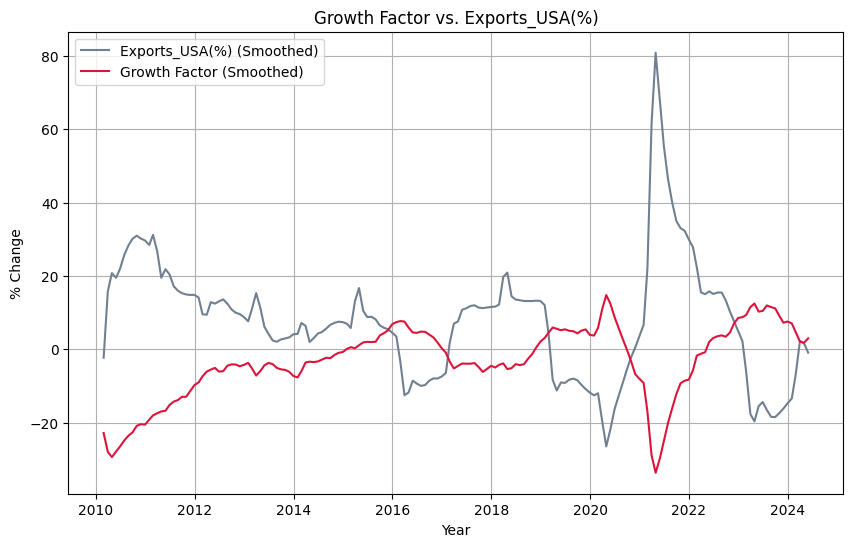

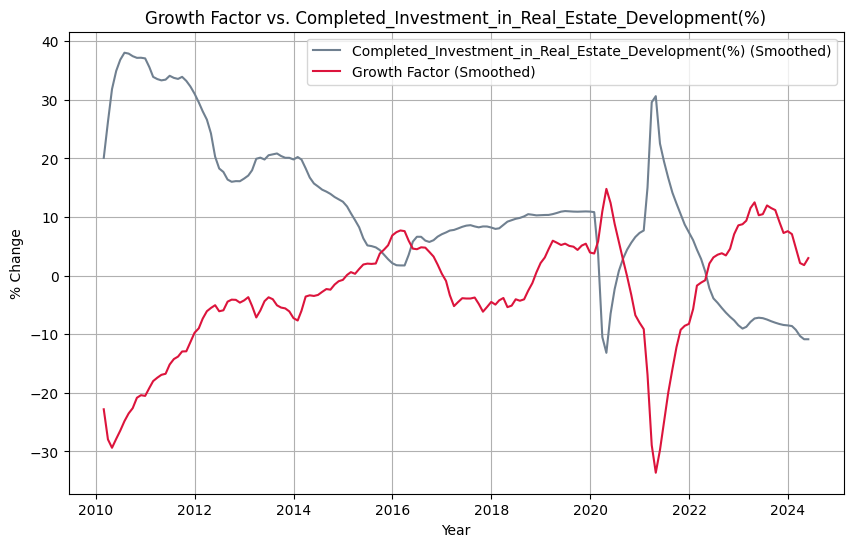

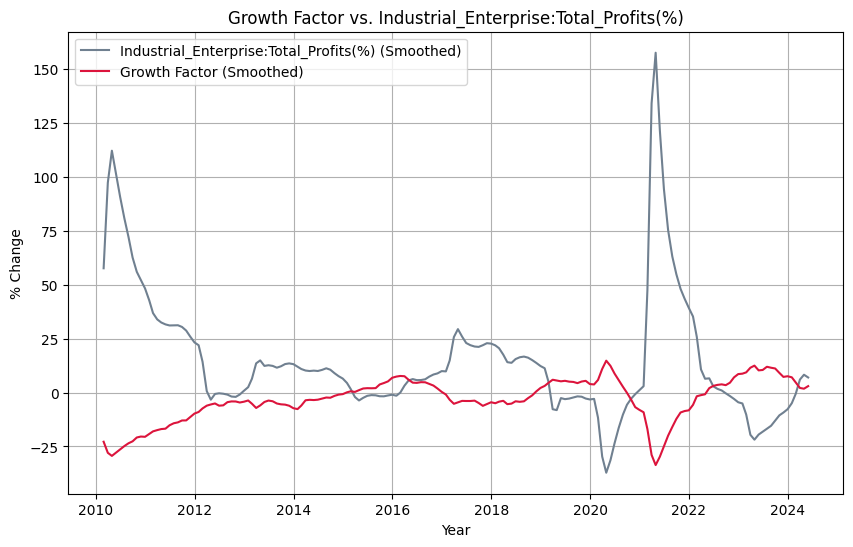

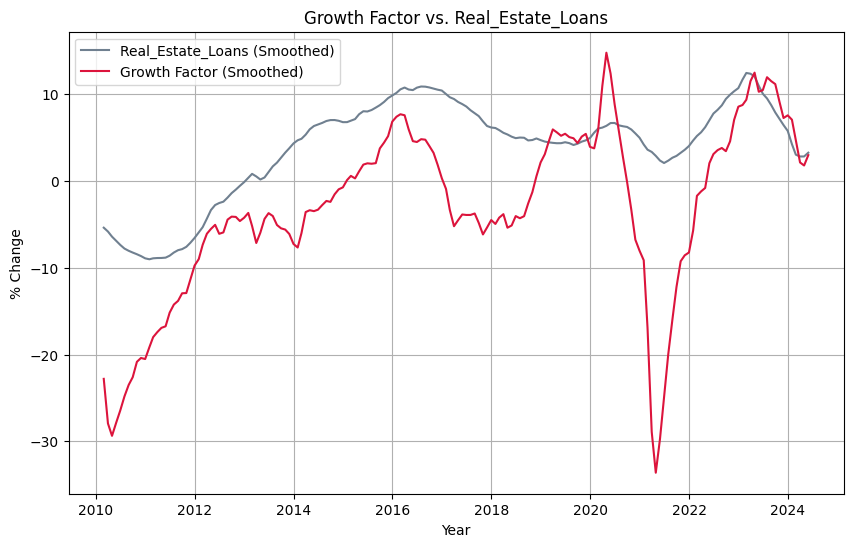

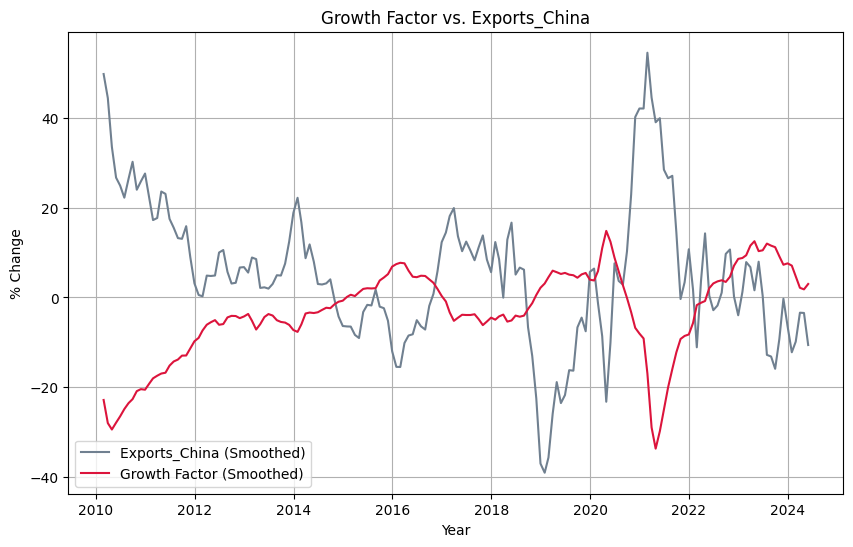

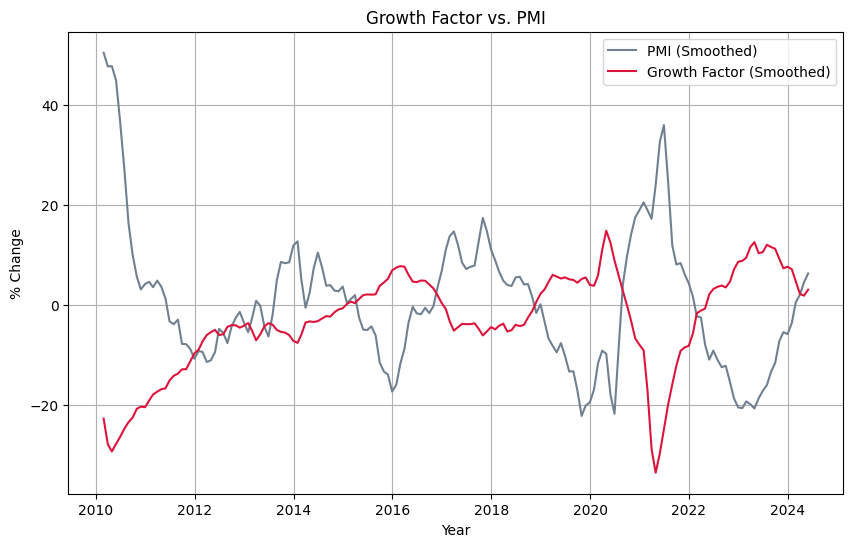

In [23]:
# Plot the data
for cg in china_growth:
    plot_smoothed_data("Growth", growth, df_china_growth, cg)
for usg in us_growth:
    plot_smoothed_data("Growth", growth, df_us_growth, usg)


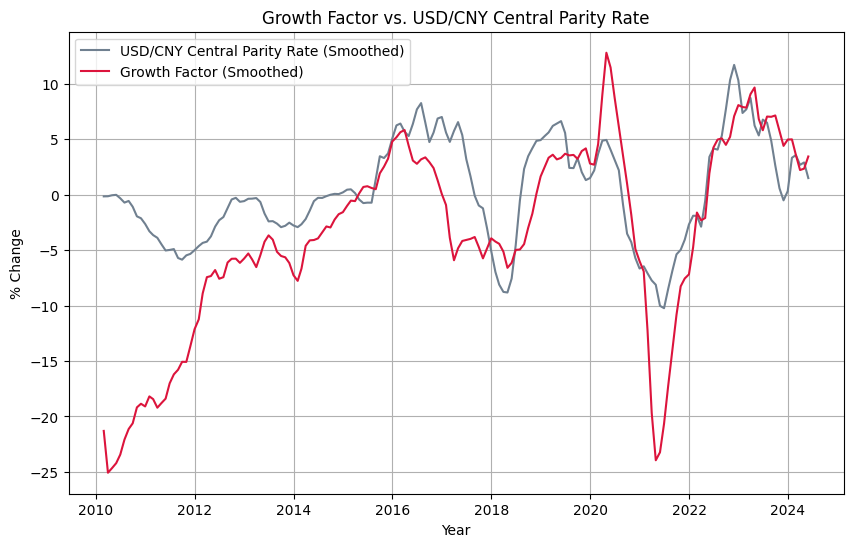

In [21]:
plot_smoothed_data("Growth", growth, df_forex, "USD/CNY Central Parity Rate")

## Inflation Factor